<a href="https://colab.research.google.com/github/LaurensEiroa/Narma10-System-Identification/blob/master/DelayBasedReservoir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as linfit

In [0]:
m = 1 # Number of input channels
n = 400 # Number of reservoir nodes
t = 800 # Length of the serie
NRMSE = lambda y,y_fit: np.mean(((y-y_fit)**2)/np.var(y))

In [0]:
def create_data(t):
  u = np.random.uniform(0,0.5,t) # Input values
  # NARMA sequence
  y = np.zeros(t)
  for i in range(t-1):
    sum_t = np.sum(y[0:i]) if i <= 9 else np.sum(y[i-9:i+1])
    if i <= 9:
      y[i+1] = 0.3 * y[i] + 0.05 * sum_t * y[i] + 0.1
    else:
      y[i+1] = 0.3 * y[i] + 0.05 * sum_t * y[i] + 1.5 * u[i] * u[i - 9] + 0.1
  u = u[20:]
  y = y[20:]
  return u, y

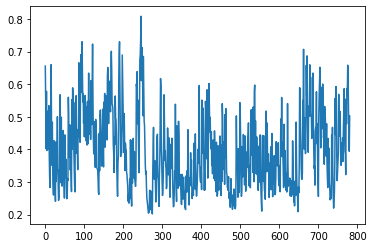

In [4]:
u, y = create_data(t)
x = np.linspace(0,u.shape[0],u.shape[0])
# Visualize the NARMA sequence
plt.plot(x,y)
plt.show()

In [5]:
theta = 0.2  # node separation
eta = 0.7  # feedback strength
gamma = 0.05  # input scaling
p = 1 # Degree of non-linearity of the MackeyGlass

input_mask = np.random.randint(-1, 2, (n))
input_mask.shape

(400,)

In [0]:
def fit_model(us,y, mask, theta, eta, gamma, p,train=True):
  nb_steps = 5
  step_size = theta / nb_steps
  state = np.zeros((mask.size * nb_steps * us.size))

  input_stream = np.repeat(us[:, None], mask.size * nb_steps, axis=1)
  input_stream = np.reshape(input_stream, mask.size * nb_steps * us.size)

  mask_mat = np.repeat(mask[:, None], nb_steps, axis=1)
  mask_mat = np.reshape(mask_mat, mask_mat.size)
  mask_mat = np.repeat(mask_mat[None, :], us.size, axis=0)
  mask_mat = np.reshape(mask_mat, mask_mat.size)

  injection_stream = input_stream * mask_mat
  for i in range(1, state.size):
      if i < mask.size * nb_steps:
          num = gamma * injection_stream[i - 1]
      else:
          num = state[i - mask.size * nb_steps] + gamma * injection_stream[i - 1]
      den = 1 + num ** p
      state[i] = state[i - 1] + step_size * (-state[i - 1] + eta * num / den)
  state = state[nb_steps - 1::nb_steps]
  state = np.reshape(state, (us.size, mask.size)).T
  state = np.concatenate((state,np.ones((1,state.shape[1]))),axis=0)

  w_out = None
  if train:
    # Use Tikhonov Regularization to fit the model and generalize on unseen data
    regression = linfit.BayesianRidge(n_iter=3000, tol=1e-8, verbose=True, fit_intercept=False)
    # regression = linfit.LinearRegression()
    # Remove the first element of the resevoir since does not consider the previous state of the reservoir
    regression.fit(state[:,1:].T, y[1:])
    w_out = regression.coef_
  return w_out, state

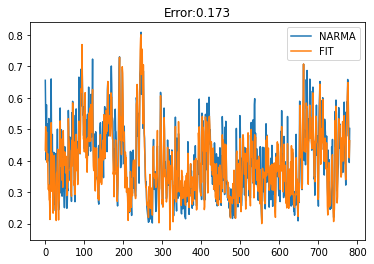

In [7]:
wout, state = fit_model(u, y, input_mask, theta, eta, gamma, p,train=True)
y_fit = wout.T@state
error = NRMSE(y,y_fit)
plt.plot(x,y,label="NARMA")
plt.plot(x,y_fit,label="FIT")
plt.legend()
plt.title("Error:"+str(round(error,3)))
plt.show()

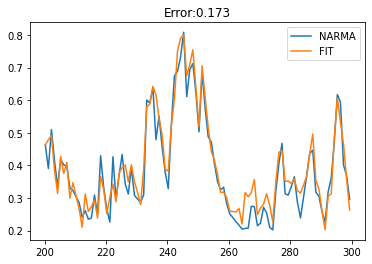

In [8]:
plt.plot(x[200:300],y[200:300],label="NARMA")
plt.plot(x[200:300],y_fit[200:300],label="FIT")
plt.legend()
plt.title("Error:"+str(round(error,3)))
plt.show()

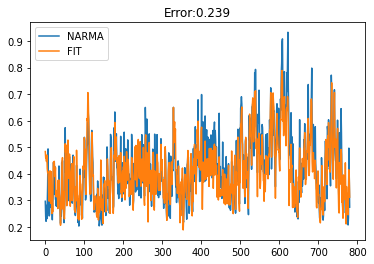

In [9]:
u_test,y_test = create_data(t)
_, state_test = fit_model(u_test, y_test, input_mask, theta, eta, gamma, p,train=False)
y_test_fit = wout.T@state_test
error_test = NRMSE(y_test,y_test_fit)
plt.plot(x[:],y_test[:],label="NARMA")
plt.plot(x[:],y_test_fit[:],label="FIT")
plt.legend()
plt.title("Error:"+str(round(error_test,3)))
plt.show()

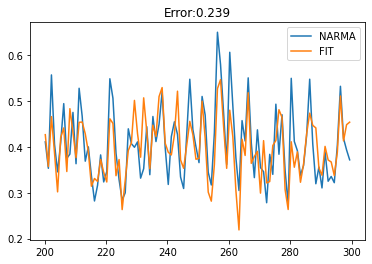

In [10]:
plt.plot(x[200:300],y_test[200:300],label="NARMA")
plt.plot(x[200:300],y_test_fit[200:300],label="FIT")
plt.legend()
plt.title("Error:"+str(round(error_test,3)))
plt.show()